In [ ]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection

#### Constants

In [2]:
RANDOM_SEED = 42
DICT_SIZE = 10000
TEST_SIZE = 10000
DEV_SIZE = 10000
PATH = '../data/communities/default/versions/word-lstm/'
GLOVE_PATH = '../data/glove.twitter.27B.50d.txt'
EMBED_SIZE = 50
PADDING = 100

TRAIN = False
SAVE = False

## Preparations

Let's load dataset

In [3]:
core = pd.read_csv("../data/toxic-comment/core.csv")
core.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
id              159571 non-null object
comment_text    159571 non-null object
base_class      159571 non-null int64
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [4]:
core.head(3)

,id,comment_text,base_class
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0


In [5]:
train, test = model_selection.train_test_split(core, test_size=(TEST_SIZE + DEV_SIZE), random_state=RANDOM_SEED,
                                               stratify=core.loc[:, 'base_class'])
dev, test = model_selection.train_test_split(test, test_size=TEST_SIZE, random_state=RANDOM_SEED,
                                             stratify=test.loc[:, 'base_class'])
print(len(train), len(test), len(dev))
train.head(3)

139571 10000 10000


,id,comment_text,base_class
62257,a696d526522491f3,", I agree, but until yesterday I was simply st...",0
53024,8db3c98f026f4df8,"""\n Agree with Gamaliel. I don't see any harm ...",0
14787,270e407e9efd6c28,"""\n\nSpeedy deletion of The Wrong Trousers (Ba...",0


## Juicy part

### Data transformations

##### Prepare tokenizer

In [6]:
from tensorflow.python.keras.preprocessing import text, sequence

In [7]:
if TRAIN:
    tokenizer = text.Tokenizer(num_words=DICT_SIZE)
    tokenizer.fit_on_texts(train.loc[:, 'comment_text'])

* on Macbook  
Tokenizer fits on texts in:  
8.96 s ± 421 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### Prepare embedding matrix

In [8]:
def build_embeddings_index(emb_file):
    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(emb_file, encoding='utf-8'))
    _ = embeddings_index.pop('0.45973')   # probably, this was escaped character,
                                        # which is not read properly
                                        # so, it has 49 coefficients instead of 50
    return embeddings_index

def build_embedding_matrix(emb_index, tokenizer, max_features, embed_size):
    all_embs = np.stack(emb_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()

    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = emb_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

* on Macbook  
build_embedding_index  
Wall time: 18.5 s  
* on Macbook  
build_embedding_matrix  
Wall time: 2 s

In [10]:
if TRAIN:
    emb_index = build_embeddings_index(GLOVE_PATH)
    print('embedding index built')
    embedding_matrix = build_embedding_matrix(emb_index, tokenizer, DICT_SIZE, EMBED_SIZE)
    print('embedding matrix built')

In [11]:
from tensorflow.python.keras import layers
from tensorflow.python.keras import models


def create_LSTM_baseline_model(seq_length, max_features, embed_size, embedding_matrix):
    inp = layers.Input(shape=(seq_length,))
    x = layers.Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = layers.Bidirectional(layers.CuDNNLSTM(50, return_sequences=True))(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Dense(50, activation="relu")(x)
    x = layers.Dropout(rate=0.1)(x)
    x = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
if TRAIN:
    model = create_LSTM_baseline_model(PADDING, DICT_SIZE, EMBED_SIZE, embedding_matrix)

In [13]:
if TRAIN:
    tokenized = tokenizer.texts_to_sequences(train['comment_text'])
    padded = sequence.pad_sequences(tokenized, maxlen=PADDING)

In [14]:
if TRAIN:
    model.fit(padded, train['base_class'], batch_size=256, epochs=2)

#### Save model and tokenizer

In [15]:
if SAVE:
    joblib.dump(tokenizer, PATH + '/tokenizer.joblib')
    model.save(PATH + "/model.h5", overwrite=True)

## Model evaluation

In [16]:
from sklearn import metrics

load model if needed

In [19]:
if not TRAIN:
    model = models.load_model(PATH + "/model.h5")
    tokenizer = joblib.load(PATH + '/tokenizer.joblib')

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


##### Single number metrics

In [20]:
dev_ready = sequence.pad_sequences(
    tokenizer.texts_to_sequences(dev['comment_text']), maxlen=PADDING
)

In [21]:
predicted_probas = model.predict(dev_ready, verbose=1).squeeze()
predicted = (predicted_probas > 0.5).astype(int)
real = dev.loc[:, 'base_class']

10000/10000 [==============================] - 4s 395us/step


* Accuracy

In [22]:
acc = metrics.accuracy_score(predicted, real)
acc

0.9627

* Balanced accuracy

In [23]:
b_acc = metrics.balanced_accuracy_score(predicted, real)
b_acc

0.9215702213540152

* ROC-AUC

In [24]:
roc_auc = metrics.roc_auc_score(real, predicted_probas)
roc_auc

0.976455746027868

##### Confusion matrix

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 33.0, 'Predicted label')

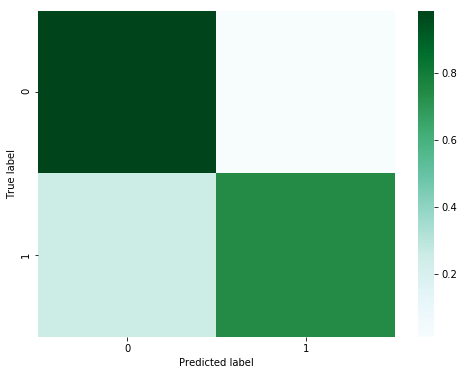

In [26]:
confusion_matrix = metrics.confusion_matrix(real, predicted)
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
# cm_df = pd.DataFrame(confusion_matrix, index=[], columns=[])
plt.figure(figsize=(8, 6))
_ = sns.heatmap(confusion_matrix, cmap='BuGn')
plt.ylabel('True label')
plt.xlabel('Predicted label')

##### Curves

* ROC

In [27]:
def plot_roc(fpr, tpr):
    plt.figure(figsize=(8, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

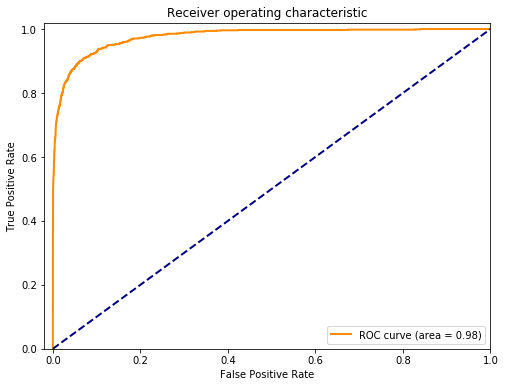

In [28]:
fpr, tpr, thresholds_roc = metrics.roc_curve(real, predicted_probas)
plot_roc(fpr, tpr)

* precision recall curve

In [29]:
def plot_prc(precision, recall):
    plt.figure(figsize=(8, 6))
    lw = 2
    plt.plot(precision, recall, color='darkorange', lw=lw, label='PR curve')
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.02])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-recall curve')
    plt.legend(loc="lower right")
    plt.show()

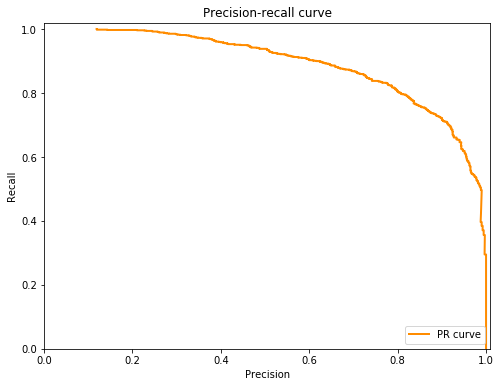

In [30]:
prec, rec, thresholds_prc = metrics.precision_recall_curve(real, predicted_probas)
plot_prc(prec, rec)